# 3.1 Analysis

In [1]:
import pandas as pd 
import glob
import re
import sys
import concurrent.futures
from Analysis import Analysis
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)

### Calculate the result for each bug

In [2]:
root = "/home/jovyan/work"
analyzer = Analysis(root)

projects = [ 
    "Cli", "Closure", "Time", "JacksonXml", "Collections", "Codec", "JxPath",
    "Compress", "Csv", "JacksonCore", "JacksonDatabind", 
    "Jsoup", "Lang", "Math", "Gson", "Mockito"
]
future_results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    for project in projects:
        # FOR EACH BUG
        for bug_path in glob.glob("{root}/results/{project}/Bug_*/".format(root=root, project=project)):
            bug = re.search(r"Bug_(\d+)", bug_path).group(1)
            try:
                future = executor.submit(analyzer.analyzeBug, project, bug, False)
                future_results.append(future)
            except Exception as e:
                print(bug_path)
                print(e)

In [3]:
bug_results = []
for future in future_results:
    r = future.result() 
    bug_results.append(r)

### Example of bug result

In [4]:
bug_results[0]

{'id': 'Cli_Bug_28',
 'bug': 'Bug_28',
 'project': 'Cli',
 'fix_pass': True,
 'prev_fails': True,
 'category': 'No regression is detected',
 'sub_category': '-',
 'test_name': 'testPropertyOptionFlags',
 'bug_report': 'https://issues.apache.org/jira/browse/CLI-201',
 'fix_commit': '3433f467554985a6bd9bf530a4810376be6fe250',
 'BIC_candidates': [],
 'executionsOnPast': 302,
 'buildFail': 185,
 'buildTestFail': 128,
 'numCommits': 615,
 'totalDays': 2927,
 'transplantability_days': 1936,
 'transplantability_position': 447}

In [5]:
resume_df= pd.DataFrame(bug_results)[
    ['id', 'project','executionsOnPast', 'numCommits', 'totalDays',
     'buildFail', 'buildTestFail', 'BIC_candidates', 'transplantability_days', 'transplantability_position']
]

resume_df['one_bic_found'] = resume_df.apply (
    lambda row: 1 if len(row['BIC_candidates']) == 1 else 0, axis=1
)
resume_df['n_bic_found'] = resume_df.apply (
    lambda row: 1 if len(row['BIC_candidates']) > 1 else 0, axis=1
)
resume_df['executionsOnPast_rate'] = resume_df.apply (
    lambda row: row['executionsOnPast'] * 100 / row['numCommits'], axis=1
)
resume_df['compilability'] = resume_df.apply (
    lambda row: (row['numCommits']-row['buildFail']) * 100 / row['numCommits'], axis=1
)
resume_df['testCompilability'] = resume_df.apply (
    lambda row: (row['numCommits']-row['buildTestFail']-row['buildFail']) * 100 / row['numCommits'], axis=1
)

resume_df['transplantability_days_ratio'] = resume_df.apply (
    lambda row: (row['transplantability_days'] * 100) / row['totalDays'], axis=1
)
resume_df['transplantability_position_ratio'] = resume_df.apply (
    lambda row: (row['transplantability_position'] * 100) / row['numCommits'], axis=1
)

## RQ1A: “How far can a test be transplanted into the past”

In [6]:
resume_df.groupby('project').agg(
    bugs=('project','size'), 
    transplantability_days_mean=('transplantability_days','mean'),
    transplantability_days_median=('transplantability_days','median'),
    transplantability_days_percentage=('transplantability_days_ratio','mean'),
    transplantability_position_mean=('transplantability_position','mean'),
    transplantability_position_median=('transplantability_position','median'),
    transplantability_position_percentage=('transplantability_position_ratio','mean')
).round(2)#.astype(int)

,bugs,transplantability_days_mean,transplantability_days_median,transplantability_days_percentage,transplantability_position_mean,transplantability_position_median,transplantability_position_percentage
project,,,,,,,
Cli,39,910.95,1168.0,36.09,134.41,115.0,34.67
Closure,174,235.27,108.5,36.74,453.09,192.0,39.79
Codec,18,703.50,427.0,22.17,195.17,83.0,21.58
Collections,4,599.00,703.0,11.05,178.75,213.5,6.30
Compress,47,1883.11,2021.0,47.48,1222.19,1326.0,82.12
Csv,16,106.81,41.5,3.11,41.38,27.5,5.17
Gson,18,1283.67,1212.5,47.60,481.33,368.0,41.70
JacksonCore,26,444.81,450.5,32.98,262.58,258.5,34.00
JacksonDatabind,112,718.28,666.0,43.92,1183.40,1123.0,40.74


In [7]:
t_days = resume_df['transplantability_days']
t_position = resume_df['transplantability_position']
t_days_ratio = resume_df['transplantability_days_ratio']
t_position_ratio = resume_df['transplantability_position_ratio']
print("Transplantability in days (Mean/Median/Ratio): %d %d %.2f"%(t_days.mean(), t_days.median(), t_days_ratio.mean()))
print("Transplantability in # commits (Mean/Median/Ratio): %d %d %.2f"%(t_position.mean(), t_position.median(), t_position_ratio.mean()))

Transplantability in days (Mean/Median/Ratio): 588 308 32.53
Transplantability in # commits (Mean/Median/Ratio): 532 215 33.43


,count,mean,std,min,25%,50%,75%,max
transplantability_days,809,588,705,0,87,308,830,3475
transplantability_position,809,532,695,1,76,215,720,3709


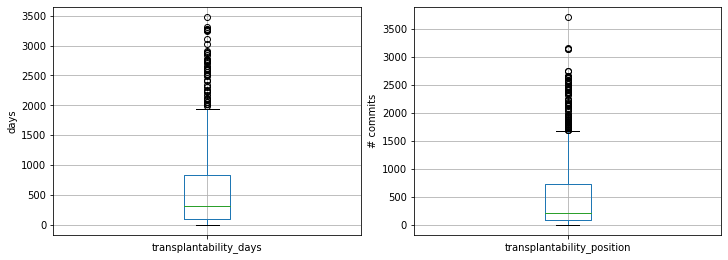

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 3.5), layout="constrained")

resume_df.boxplot(column='transplantability_days', ax=axs[0])
axs[0].set_ylabel("days")

resume_df.boxplot(column='transplantability_position', ax=axs[1])
axs[1].set_ylabel("# commits")

resume_df[['transplantability_days', 'transplantability_position']].describe().astype(int).T

In [9]:
for bug in bug_results:
    if bug['transplantability_position'] < 1:
        print(bug)

In [10]:
regressions_df = pd.DataFrame(bug_results)[
    ['id', 'project','category', 'sub_category', 'bic_position', 'bic_age']
]
regressions_df = regressions_df[regressions_df['sub_category']=='Unique candidates']
bic_position = regressions_df['bic_position']
bic_age = regressions_df['bic_age']
print("BIC position (Mean/Median): %d %d"%(bic_position.mean(), bic_position.median()))
print("BIC age (Mean/Median): %d %d"%(bic_age.mean(), bic_age.median()))

BIC position (Mean/Median): 177 42
BIC age (Mean/Median): 185 39


## RQ1B: “How compilability and runnability problems impact the transplantation of the regression tests to the past?”

In [11]:
resume_df_agg = resume_df.groupby('project').agg(
    bugs=('project','size'), 
    #s_bics=('one_bic_found','sum'),
    #m_bics=('n_bic_found','sum'),
    compilability_mean=('compilability','mean'), 
    compilability_median=('compilability','median'),
    test_compilability_mean=('testCompilability','mean'), 
    test_compilability_median=('testCompilability','median'),
    ratio_mean=('executionsOnPast_rate','mean'), 
    ratio_median=('executionsOnPast_rate','median'),
)
compilability = resume_df['compilability']
t_compilability = resume_df['testCompilability']
t_runnability = resume_df['executionsOnPast_rate']
print("Src Compilability (Mean/Median): %.2f %.2f"%(compilability.mean(), compilability.median()))
print("Test Compilability (Mean/Median): %.2f %.2f"%(t_compilability.mean(), t_compilability.median()))
print("Test runability (Mean/Median): %.2f %.2f"%(t_runnability.mean(), t_runnability.median()))
resume_df_agg.round(2)

Src Compilability (Mean/Median): 53.28 49.43
Test Compilability (Mean/Median): 20.47 12.36
Test runability (Mean/Median): 20.32 12.10


,bugs,compilability_mean,compilability_median,test_compilability_mean,test_compilability_median,ratio_mean,ratio_median
project,,,,,,,
Cli,39,56.07,62.61,29.40,30.88,29.40,30.88
Closure,174,59.41,54.36,33.69,17.82,33.69,17.82
Codec,18,23.74,14.29,20.44,8.84,20.44,8.84
Collections,4,97.94,98.98,5.73,7.46,5.61,7.37
Compress,47,29.90,23.60,20.75,17.02,18.29,10.22
Csv,16,19.07,17.38,5.26,3.51,5.21,3.51
Gson,18,42.00,35.98,40.73,34.68,40.73,34.68
JacksonCore,26,35.08,32.54,31.52,30.12,31.52,30.12
JacksonDatabind,112,88.37,90.17,13.77,14.22,13.77,14.22


In [12]:
resume_df[['compilability','testCompilability','executionsOnPast_rate']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
compilability,809.0,53.28,32.20,1.58,24.88,49.43,84.25,100.00
testCompilability,809.0,20.47,23.10,0.10,4.36,12.36,26.58,99.57
executionsOnPast_rate,809.0,20.32,23.12,0.10,4.35,12.10,26.41,99.57


## RQ2: “Can the BIC for a given bug be found using its regression test?”

### Summary of results

In [13]:
df = pd.DataFrame(bug_results)[['id', 'project','category', 'sub_category']]
df[df['category'] != None].set_index('id').sort_index()
print(len(df))
df.groupby(['category', "sub_category"]).count()['id']

809


category                   sub_category       
A regression is detected   Multiple candidates     29
                           Unique candidates       69
No regression is detected  -                      711
Name: id, dtype: int64